In [1]:
import pandas as pd 
import numpy as np 
import geopandas as gpd 
import sys
import matplotlib.pyplot as plt 
import pickle

In [2]:
class election_data:
        
    def __init__ (self, rp): 
        ## Root Path for election results
        self.results_path = rp
        ## Creating Key DataFrame
        self.__election_frame__ = pd.read_excel(rp)
        self.key_frame = self.__key_transform__()
        
        ## Creating relations for individual measures
        self.contests = self.__contest_dictionary__()
        
        ## Shapefile for all georgia counties
        self.ga_counties = self.load_county_map()
        
        self.vote_key = ["ElectionDay", "Absentee", "Advanced", "Provisional", "Total"]
        
    def load_county_map(self, state_id = 13):
        """Loads map of all the counties in the given state through a shapefile
        
        Key Arguments: 
        @state_id the state that is being loaded defaults to loading georgia
        """
        us_counties = gpd.read_file("../shapefiles/county_shapefiles//tl_2017_us_county.shp")
        return us_counties[us_counties['STATEFP'] == str(state_id)]
    
    def contest_transform(self, df): 
        """Set of Transforms used to create a dictionary with all the contests from that 
        particular election. Creates a vector of results for every candidate

        Key Arguments: 

        df - the dataframe to perform the transformations on 
        """
        
        return_frame = pd.DataFrame()
        return_frame["NAME"] = df[df.columns[0]].drop([0,1])
        for i, candidate in enumerate(list(df.loc[0].dropna())):
            start = 5*i + 1 
            end = start + 5
            return_frame[candidate] = df.drop([0,1]).apply(lambda row: tuple(row.iloc[start:end].astype("int32")), axis = 1)
    
        return_frame.reset_index(inplace = True)
        return_frame.drop("index", axis = 1, inplace = True)
        
        return return_frame
    
    def __key_transform__(self): 
        """Transforms the first page of election results into a desirable format"""
        df = self.__election_frame__
        # Drop the first two rows because no useful information is contained
        df.drop([0,1], inplace = True)
        
        # Rename columns
        col_names = [df.iloc[0][i] for i in range(len(df.columns))]
        df.rename(columns = {current: new for current, new in zip(df.columns, col_names)}, inplace = True)
        
        # Drop Extra Row
        df.drop([2], inplace = True)
        
        return df
    
    def __contest_dictionary__(self):
        """Creates a dictionary of every single contest that took place in the election"""
        empty_dict = {}
        col1, col2 = self.key_frame.columns
        for page, contest in zip(self.key_frame[col1], self.key_frame[col2]):
            empty_dict[contest] = self.contest_transform(pd.read_excel(self.results_path, sheet_name = page))
        
        return empty_dict
    
    def save(self, path): 
        outfile = open(path, 'wb')
        pickle.dump(path, outfile)
        outfile.close()
        
    def load(path): 
        infile = open(path, 'rb')
        return_obj = pickle.load(infile)
        infile.close()
        return return_obj
        
    

In [3]:
class election_plotter: 
    
    def __init__ (self, ed): 
        ## Election Data Object
        self.df = ed
        self.map = ed.ga_counties 
        
    
    def plot(self, 
             data, 
             col = None, 
             style = "fivethirtyeight", 
             size = (20, 10),
             color = "coolwarm"):
        
        ## Setting some plot styles 
        plt.style.use(style)
        plt.rcParams["figure.figsize"] = size
        ## Creating the dataframe that will be used for plotting
        combined_geo_frame = gpd.GeoDataFrame(pd.merge(self.map, data, on = "NAME"))
        
        if col: 
            fig, ax = plt.subplots(1)
            ax.axis("off")

            combined_geo_frame.plot(column = col, ax = ax, cmap = color, legend = True)
        else: 
            combined_geo_frame.plot()
    
    

In [4]:
%time results_2020 = election_data("../data/georgia_elections_data/2020General/detail.xls.xlsx")

Wall time: 2min 46s


In [9]:
pickled_results = election_data.load("results_2020.pkl")

In [5]:
def test(ed): 
    data = ed.contests["President of the United States"]
    data["total"] = data.apply(lambda row: sum(row[data.columns[i]][4] for i in range(1, 4)), axis = 1)
    data["trump_prop"] = data.apply(lambda row: row[data.columns[1]][4] /row["total"], axis = 1)
    election_plotter(ed).plot(data, col = "trump_prop")

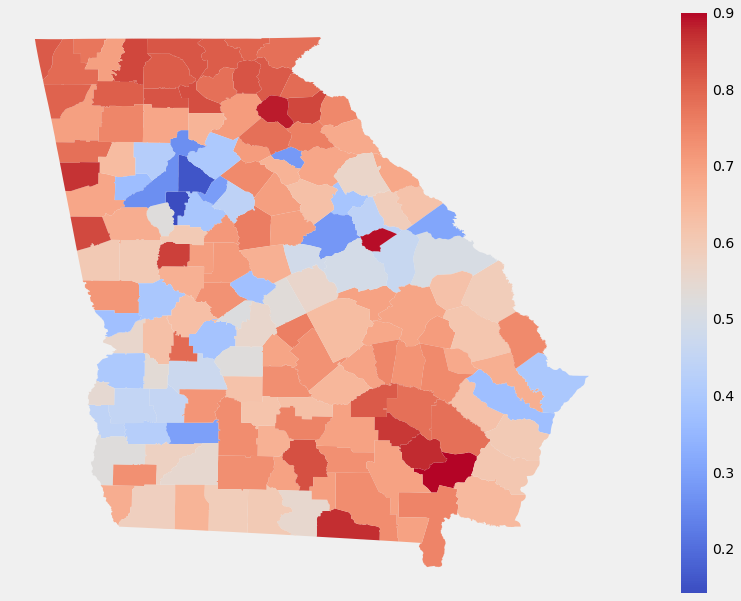

In [11]:
test(pickled_results)
plt.savefig("../plots/2020PresidentialResults.png")

In [12]:
pickled_results.key_frame

,Page,Contest
3,1,President of the United States
4,2,US Senate (Perdue)
5,3,US Senate (Loeffler) - Special
6,4,Public Service Commission District 4
7,5,Public Service Commission District 1
...,...,...
296,294,District Attorney - Bell-Forsyth
297,295,District Attorney - Towaliga
298,296,Constitutional Amendment #1
299,297,Constitutional Amendment #2


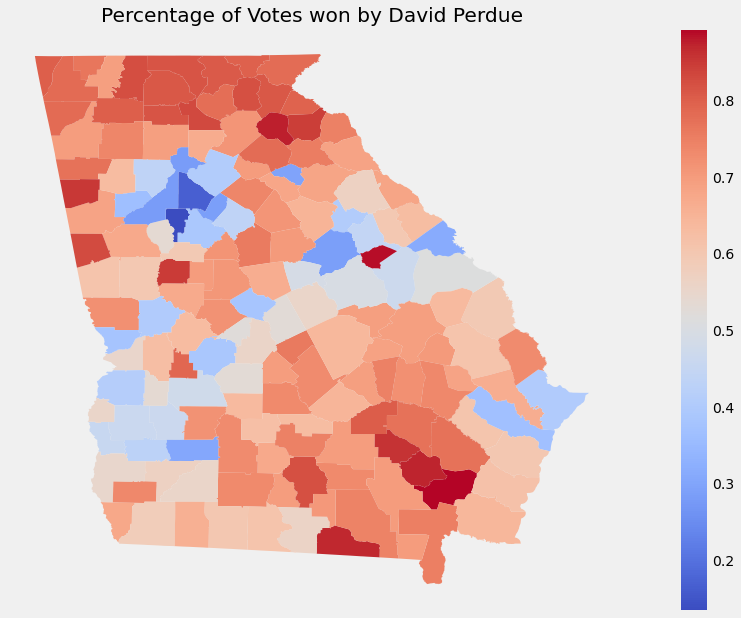

In [19]:
data = pickled_results.contests["US Senate (Perdue)"]
data["total"] = data.apply(lambda row: sum(row[data.columns[i]][4] for i in range(1, 4)), axis = 1)
data["perdue_prop"] = data.apply(lambda row: row[data.columns[1]][4] /row["total"], axis = 1)
election_plotter(pickled_results).plot(data, col = "perdue_prop")
plt.title("Percentage of Votes won by David Perdue")
plt.savefig("../plots/2020SenatePerdueResults.png")

In [20]:
data1 = pickled_results.contests["President of the United States"]
data1["total"] = data1.apply(lambda row: sum(row[data1.columns[i]][4] for i in range(1, 4)), axis = 1)
data1["trump_prop"] = data1.apply(lambda row: row[data1.columns[1]][4] /row["total"], axis = 1)


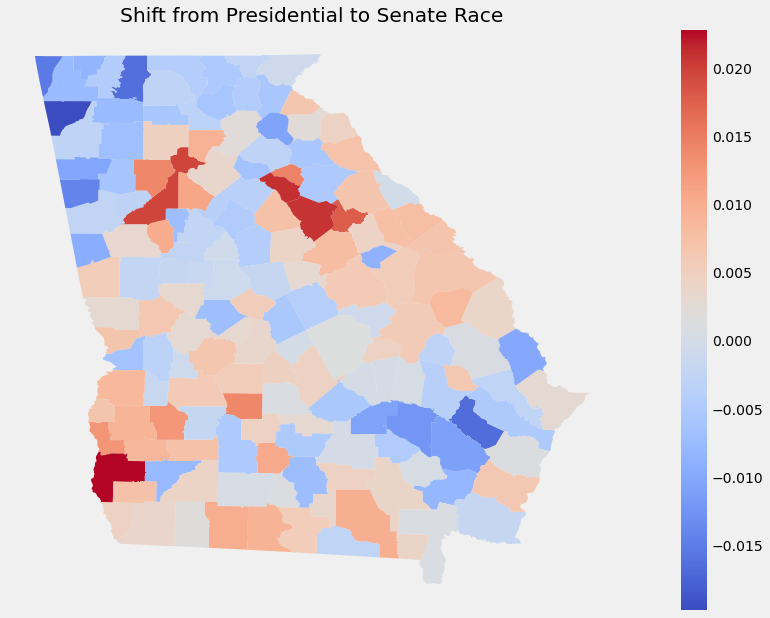

In [31]:
data2 = pd.DataFrame()
data2["dropoff"] =  data["perdue_prop"] - data1["trump_prop"]
data2["NAME"] = data["NAME"]
election_plotter(pickled_results).plot(data2, col="dropoff")
plt.title("Shift from Presidential to Senate Race")
plt.savefig("../plots/2020Shift.png")

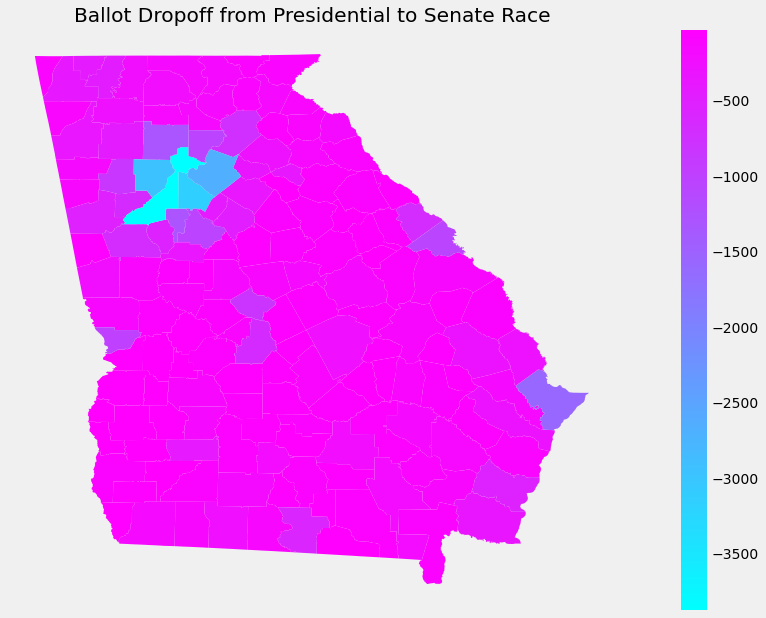

In [32]:
data2 = pd.DataFrame()
data2["dropoff"] =  data["total"] - data1["total"]
data2["NAME"] = data["NAME"]
election_plotter(pickled_results).plot(data2, col="dropoff", color="cool")
plt.title("Ballot Dropoff from Presidential to Senate Race")
plt.savefig("../plots/2020Dropoff.png")